## Imports

In [1]:
import random
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
  

In [2]:
# Set random seed for PyTorch
torch.manual_seed(42)

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for Python's random module
random.seed(42)

In [3]:
batch_size = 256
dataset_dir = 'flowers_new'

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize the input data using ImageNet statistics
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# Load the datasets
train_dataset = torchvision.datasets.ImageFolder(
    root=f'{dataset_dir}/train',
    transform=transform
)
val_dataset = torchvision.datasets.ImageFolder(
    root=f'{dataset_dir}/val',
    transform=transform
)
test_dataset = torchvision.datasets.ImageFolder(
    root=f'{dataset_dir}/test',
    transform=transform
)

# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [5]:
len(val_loader.dataset.samples)

1679

In [6]:
# Initialize the ResNet-18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze the parameters of all layers
for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

print(model)

/home/matthew/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matthew/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [8]:
# Training loop
num_epochs = 30
min_loss = np.inf
tic = time.time()
val_losses = []
train_losses = []
val_accs = []
train_accs = []

for epoch in range(num_epochs):
    print(f'training... epoch {epoch}')
    running_loss = 0.0
    running_corr = 0.0
    val_loss = 0.0
    val_corr = 0.0
    #model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corr += torch.sum(preds == labels.data)
    model.eval()   
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            vloss = criterion(outputs, labels)
            val_loss += vloss.item() * inputs.size(0)
            val_corr += torch.sum(preds == labels.data)
            
    running_loss = running_loss/len(train_loader.dataset.samples)
    train_acc = running_corr.double() / len(train_loader.dataset.samples)
    
    val_loss = val_loss/len(val_loader.dataset.samples)
    val_acc = val_corr.double() / len(val_loader.dataset.samples)
    
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())
    train_losses.append(running_loss)
    train_accs.append(train_acc.item())
    
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model, 'resnet_model.pth')
        print(f'saving model at epoch {epoch}')
        print(f'Epoch {epoch + 1} loss {running_loss:.3f} val_loss {val_loss:.3f}  train acc: {train_acc:.3f} val acc: {val_acc:.3f}')
toc = time.time()            

print('Training finished!')
print(f'Total time: {abs(toc-tic)}')


training... epoch 0
saving model at epoch 0
Epoch 1 loss 1.610 val_loss 1.258  train acc: 0.447 val acc: 0.668
training... epoch 1
saving model at epoch 1
Epoch 2 loss 1.037 val_loss 0.904  train acc: 0.746 val acc: 0.774
training... epoch 2
saving model at epoch 2
Epoch 3 loss 0.787 val_loss 0.726  train acc: 0.809 val acc: 0.821
training... epoch 3
saving model at epoch 3
Epoch 4 loss 0.655 val_loss 0.636  train acc: 0.833 val acc: 0.830
training... epoch 4
saving model at epoch 4
Epoch 5 loss 0.578 val_loss 0.581  train acc: 0.848 val acc: 0.839
training... epoch 5
saving model at epoch 5
Epoch 6 loss 0.521 val_loss 0.520  train acc: 0.864 val acc: 0.858
training... epoch 6
saving model at epoch 6
Epoch 7 loss 0.486 val_loss 0.505  train acc: 0.867 val acc: 0.862
training... epoch 7
saving model at epoch 7
Epoch 8 loss 0.456 val_loss 0.471  train acc: 0.872 val acc: 0.864
training... epoch 8
saving model at epoch 8
Epoch 9 loss 0.428 val_loss 0.447  train acc: 0.881 val acc: 0.872
t

In [9]:
# Evaluation on the test set
model = torch.load('resnet_model.pth')
model.eval()  # Switch to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 89.05%


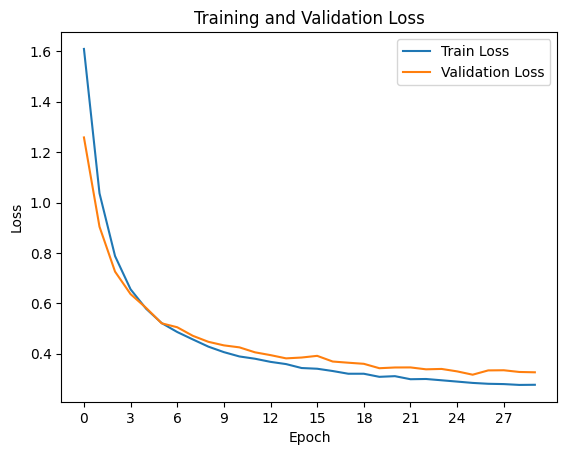

In [10]:
import matplotlib.pyplot as plt

# Example losses data
epoch = np.arange(len(train_losses))

# Plot losses
plt.plot(epoch, train_losses, label='Train Loss')
plt.plot(epoch, val_losses, label='Validation Loss')
plt.xticks(range(min(epoch), max(epoch)+1, 3), map(int, range(min(epoch), max(epoch)+1, 3)))


# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add legend
plt.legend()

# Display the plot
plt.show()


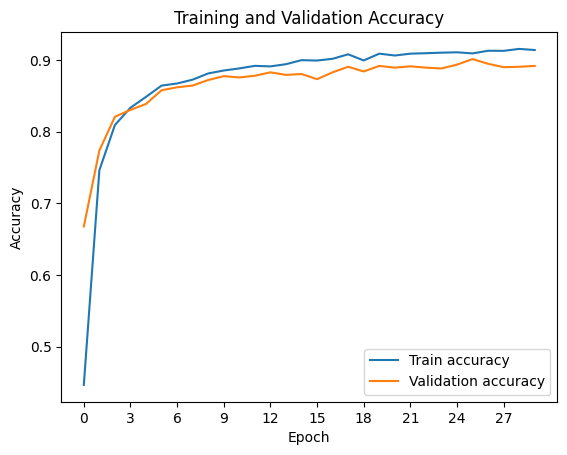

In [11]:
# Example losses data
epoch = np.arange(len(train_accs))

# Plot accs
plt.plot(epoch, train_accs, label='Train accuracy')
plt.plot(epoch, val_accs, label='Validation accuracy')
plt.xticks(range(min(epoch), max(epoch)+1, 3), map(int, range(min(epoch), max(epoch)+1, 3)))

# Set labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')


# Add legend
plt.legend()

# Display the plot
plt.show()
